In [11]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

os.chdir("..")

from util.munge import max_print, format_date
from util.data_mappings import state_full_names


warnings.filterwarnings('ignore')
matplotlib.style.use("fivethirtyeight")

In [12]:
def get_covid_tracking_daily_df():
    states = pd.read_csv("https://covidtracking.com/api/states/daily.csv")
    states["state"] = states["state"].map(state_full_names)
    states = states.sort_values(["state","date"]).reset_index()
    return states

In [13]:
daily = get_covid_tracking_daily_df()
daily.head()

,index,date,state,positive,negative,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,1305,20200307,Alabama,0.0,NaN,NaN,NaN,NaN,0,325a151673456637b44fc94c8388025710fd5f64,2020-03-07T21:00:00Z,0,1,NaN,NaN,NaN,NaN,NaN
1,1254,20200308,Alabama,0.0,NaN,NaN,NaN,NaN,0,b450f75c691f03b8c8d8b0fea04edf25d27d705a,2020-03-08T20:00:00Z,0,1,0.0,0.0,0.0,0.0,0.0
2,1203,20200309,Alabama,0.0,NaN,NaN,NaN,NaN,0,a50c218e7c6eee0c132f449a1c02232c15c4e829,2020-03-09T20:00:00Z,0,1,0.0,0.0,0.0,0.0,0.0
3,1152,20200310,Alabama,0.0,0.0,0.0,NaN,NaN,0,904cc043e463dd12d48462ba0ca02ba062622b45,2020-03-10T20:00:00Z,0,1,0.0,0.0,0.0,0.0,0.0
4,1101,20200311,Alabama,0.0,10.0,NaN,NaN,NaN,10,19465578826a31e9fd39c124bf882934566bda0d,2020-03-11T20:00:00Z,10,1,0.0,0.0,10.0,0.0,10.0


In [14]:
# daily data is prone to misreported numbers or errors
# we can smooth the reported positives by looking at 
# positive case growth every 2 days
daily["positiveIncreaseLag"] = daily.groupby("state")["positiveIncrease"].shift(1)
daily["twoDayPositiveIncrease"] = daily["positiveIncrease"] + daily["positiveIncreaseLag"]
smoothed_daily = daily.loc[daily["date"] % 2 == 0]

# plot drop off
smoothed_daily["logPositiveNew"] = np.log(smoothed_daily["twoDayPositiveIncrease"])
smoothed_daily["logPositiveTotal"] = np.log(smoothed_daily["positive"])


In [15]:
# spot check California
smoothed_daily.loc[daily["state"] == "California"][[
    "date", "twoDayPositiveIncrease", "positive"]]

,date,twoDayPositiveIncrease,positive
121,20200304,NaN,53.0
123,20200306,7.0,60.0
125,20200308,28.0,88.0
127,20200310,45.0,133.0
129,20200312,69.0,202.0
131,20200314,50.0,252.0
133,20200316,83.0,335.0
135,20200318,276.0,611.0
137,20200320,452.0,1063.0
139,20200322,473.0,1536.0


In [17]:
# plot variables and settings
latest_update = format_date(str(smoothed_daily["date"].max()))
states = ["New York", "California", "Washington", "Illinois", "New Jersey"]
to_plot = smoothed_daily.loc[daily["state"].isin(states)]

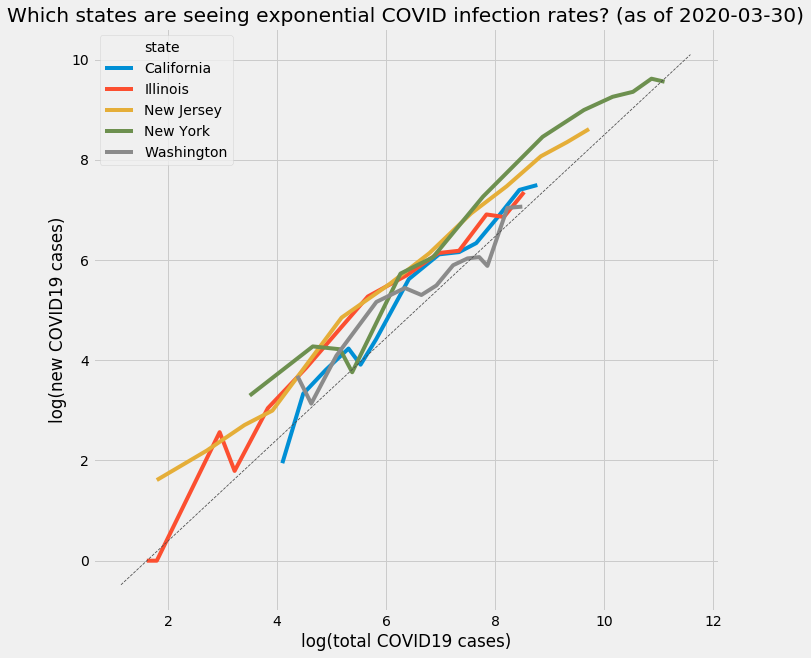

In [20]:
# log-log plot of growth rate v total (positives)
plt.figure(figsize=(10,10))
ax = sns.lineplot(
    x="logPositiveTotal",
    y="logPositiveNew",
    hue="state",
    data=to_plot
)

ax.set(
    xlabel="log(total COVID19 cases)",
    ylabel="log(new COVID19 cases)",
    title=f"Which states are seeing exponential COVID infection rates? (as of {latest_update})"
)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", lw=.8)
plt.show()

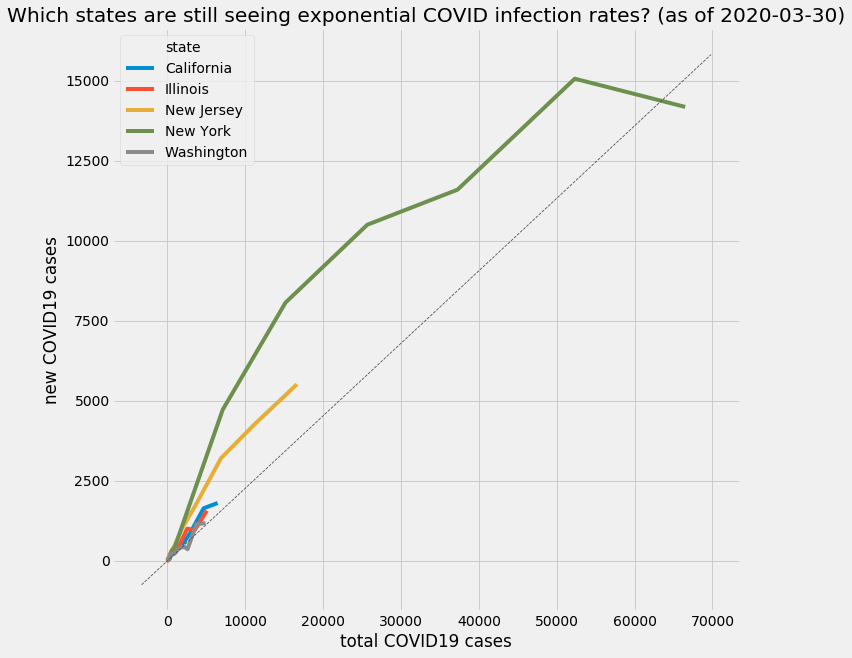

In [23]:
# linear-scale plot of growth rate v total (positives)
plt.figure(figsize=(10,10))
ax = sns.lineplot(
    x="positive",
    y="twoDayPositiveIncrease",
    hue="state",
    data=to_plot
)

ax.set(
    xlabel="total COVID19 cases",
    ylabel="new COVID19 cases",
    title=f"Which states are still seeing exponential COVID infection rates? (as of {latest_update})"
)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", lw=.8)
plt.show()